# Light-harvesting Fenna–Matthews–Olson (FMO) Complex

The FMO complex is a pigment-protein complex that can be found in green sulfur bacteria. It mediates the transfer of energy (excited electronic states, i.e., *exciton*) from the light-harvesting chlorosomes (antenna) to the reaction centre. [[wiki]](https://en.wikipedia.org/wiki/Fenna%E2%80%93Matthews%E2%80%93Olson_complex)

The FMO complex has 7 chromophores (sites) that can host an exciton with different energies $\varepsilon_i$. The chromophores are coupled to each other via Coulomb (dipole-dipole) interactions $V_{ij}$, which mediates the transfer (hopping) of an exciton between chromophores.

Reference for the model: [**Environment-assisted quantum walks in photosynthetic energy transfer**](https://doi.org/10.1063/1.3002335)


## Import modules and packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

## System Hamiltonian

Set up the system Hamiltonian for the *single-excitation* manifold, i.e., the subspace of states with exactly one exciton in the system. The Hamiltonian can be constructed from the local exciton energies ($\varepsilon_i$) for each chromophore and the inter-chromophore couplings ($V_{ij}$):

$H = \sum_{i} \varepsilon_{i}|i\rangle\langle i| + \sum_{(i,j)} \bigg( V_{ij}|i\rangle\langle j| +  h.c. \bigg) $.

**Note:** All energies and couplings are given in units of $\textrm{cm}^{-1} = 0.123983\textrm{meV}$.

Use the following energies $\varepsilon_i$, numbering the sites as $i=0,\dots,6$: 
- `[280, 420, 0, 175, 320, 360, 260]`,

Use the following couplings $V_{ij}$ for between sites $(i,j)$ in the format `(i,j,coupling)`: 
- `[(0,1,-106), (0,6,-8), (1,2,28), (1,5,13), (2,3,-62), (2,6,17), (3,4,-70), (3,5,-19), (3,6,-57), (4,5,40), (4,6,-2), (5,6,32)]`.


In [7]:
# exciton energy of each site (i = 0,...,6)
energies = [280,420,0,175,320,360,260]

# exciton couplings (i, j, coupling)
couplings = [(0,1,-106), (0,6,-8), (1,2,28), (1,5,13), (2,3,-62), (2,6,17),
             (3,4,-70), (3,5,-19), (3,6,-57), (4,5,40), (4,6,-2), (5,6,32)]

# dimension
dim = len(energies)

# basis
basis = np.eye(dim)

# build Hamiltonian from the list of energies
H = np.diag(energies)

# add couplings
# loop over the coupling assigning each value to indices and coupling strength
for i,j,V in couplings:
    # compose the coupling in operator form
    coupling = V * np.outer(basis[i],basis[j].conj().T)
    # ad the coupling and its conjugate transpose
    H = H + (coupling + coupling.conj().T)

## Eigenstates and delocalisation

Find the eigenenergies $\omega_k$ and eigenstates $|\psi_k\rangle$ of the system, $H|\phi_k\rangle = \omega_k |\phi_k\rangle$. Then calculate and plot the **inverse participation ratio** $\mathrm{IPR}(\phi_k)$ for each eigenstate,

$\mathrm{IPR}(\phi_k):=\bigg(\sum_{i}|\langle \phi_k | i\rangle |^4\bigg)^{-1}$.

The $\mathrm{IPR}$ represents the degree of delocalisation of a state. Test the following statements.
- Localised state have $\mathrm{IPR}=1$
- Delocalised states have $\mathrm{IPR}>1$
- Perfectly delocalised states $\sum_{i=1}^{N}|i\rangle/\sqrt{N}$ states have $\mathrm{IPR}=N$.

If you want sorted eigenstates you can use `eigensorter` from `tools`.

localised state: IPR = 1.0
delocalised state: IPR = 1.2513284025784297
perfectly delocalised state: IPR = 7.000000000000002


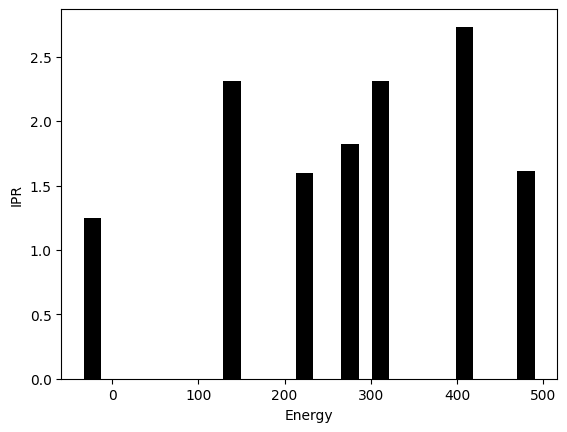

In [8]:
# import eigensorter
from tools import eigensorter

# eigenstates
evals,ekets = eigensorter(H)

# IPR
def IPR(state,basis=basis):
    # coefficients of each state on the considered basis
    coeffs = np.array([state.conj().T@b for b in basis])
    # retunr IPR
    return 1/np.sum(abs(coeffs)**4)

# plot IPR for each state
iprs = np.array([IPR(eket) for eket in ekets])
fig, ax = plt.subplots()
ax.bar(evals, iprs, color = 'black', width = 20);
ax.set_xlabel('Energy');
ax.set_ylabel('IPR');

# test IPR
print('localised state: IPR =',IPR(basis[0]));
print('delocalised state: IPR =',IPR(ekets[0]));
print('perfectly delocalised state: IPR =',IPR(sum([b for b in basis])/np.sqrt(len(basis))));

## IPR as a function of temperature

Thermal states are given by $G_\beta[H]:=\exp(-\beta H)/\mathrm{Tr}\exp(-\beta H)$, where 
- $\beta^{-1} = k_B T$ and
- $k_B = 0.695 035 6(12) \mathrm{cm}^{-1}/K$ is the Boltzmann constant.

Calculate the $\mathrm{IPR}$ for the thermal states of the system for the following interval of temperatures:

- $T = [7K, 300K]$.

**Note**: How could we generalise the $\mathrm{IPR}$ to density operators? 

<details>
<summary> Hint </summary>
<br>
Any density operator can be written as $\rho = \sum_i p_i |r_i\rangle\langle r_i|$, in some basis.
</details>

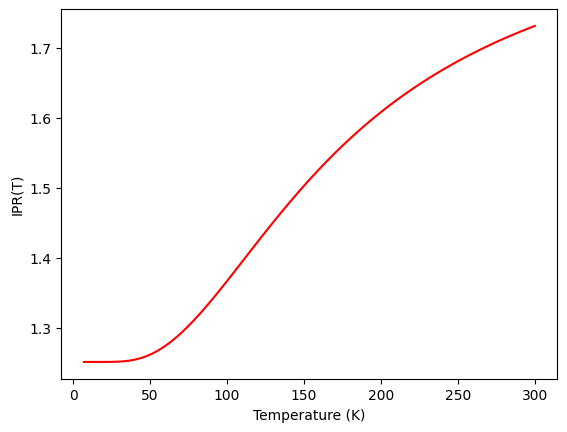

In [15]:
from scipy.linalg import expm

# thermal state
def G(H,T,kB=0.6950):
    beta = 1/(kB*T)
    temp = expm(-beta*H)
    return temp/np.trace(temp)

# temperatures 
Ts = np.linspace(7,300,100)

# thermal states
thermal_states = [G(H,T) for T in Ts]

# generalise IPR to mixed states
def meanIPR(rho):
    # eigenvalues and eigenstate of rho
    ps, ekets = eigensorter(rho)
    # return average IPR
    return np.sum([ps[k]*IPR(ekets) for k,ekets in enumerate(ekets)])

# mean IPRs
mean_iprs = np.array([meanIPR(state) for state in thermal_states])

# plot
fig, ax = plt.subplots()
ax.plot(Ts, mean_iprs, color = 'red');
ax.set_xlabel('Temperature (K)');
ax.set_ylabel('IPR(T)');

## Decoherence model

Using Bloch-Redfield theory, calculate the Redfield tensor $R$ (in the basis of the Hamiltonian) associated with the thermal relaxation process $\dot{\rho}=R[\rho]$ under the following conditions:

- Use the following (Ohmic) noise power spectrum $S(\omega,\eta,\omega_c,\beta) = 2\pi\eta\omega\exp(-|\omega|/\omega_c)[1-\exp(-\omega\beta)]^{-1}$, where:
    - $\beta^{-1}= k_B T$ is the *inverse temperature* of the bath, using $T = 300 K$, 
    - $\eta=1$ ($\textrm{cm}^{-1}$) is the *reorganisation energy*, and
    - $\omega_c = 150$ ($\textrm{cm}^{-1}$) is the *cut-off energy* of the Ohmic model.
- Use local exciton states as the coupling operators $A_i = |i\rangle\langle i|$;
- Work in the secular approximation, using a *machine-precision* cut-off value condition `secular_cut_off = 1e-15`

To construct the Redfield tensor use the [Script 4.1](https://github.com/frnq/qme/blob/main/python/bloch_redfield_tensor.py) from the [tutorial](https://arxiv.org/abs/2303.16449).

In [31]:
# compute the Bloch-Redfield tensor in the Hamiltonian's basis
def BR_tensor(H, a_ops, secular = True, secular_cut_off = 1e-15):
    dim = len(H) # dimension
    evals,ekets = np.linalg.eig(H) # HS's basis
    # sort basis
    _zipped = list(zip(evals, range(len(evals))))
    _zipped.sort()
    evals, perm = list(zip(*_zipped))
    ekets = np.array([ekets[:, k] for k in perm])
    evals = np.array(evals)
    # coupling operators in H basis
    a_ops_S = [[ekets.conjugate()@a@ekets.T,nps] for a,nps in a_ops] 
    # Bohr frequencies (w_ab)
    indices = [(a,b) for a in range(dim) for b in range(dim)]
    BohrF = np.sort(np.array([evals[a]-evals[b] for a in range(dim) for b in range(dim)]))
    # construct empty R
    R = np.zeros((dim**2,dim**2),dtype = complex) 
    for j,(a,b) in enumerate(indices): # loop over indices
        for k,(c,d) in enumerate(indices): # loop over indices
            # unitary part
            R[j,k] += -1j * (a==c)*(b==d)*(evals[a]-evals[b])
            for a_op,nps in a_ops_S: # loop over uncorrelated a_ops
                gmax = np.max([NPS(f) for f in BohrF]) # largest rate for secular approximation
                A = a_op # coupling operator
                # secular approximation test
                if secular is True and abs(evals[a]-evals[b]-evals[c]+evals[d]) > gmax*secular_cut_off:
                    pass
                else:      
                    # non-unitary part
                    R[j,k] += - 1/2 * ((b==d)*np.sum([A[a,n]*A[n,c]*nps(evals[c]-evals[n])  
                                                      for n in range(dim)])
                                                     -A[a,c]*A[d,b]*nps(evals[c]-evals[a]) +
                                       (a==c)*np.sum([A[d,n]*A[n,b]*nps(evals[d]-evals[n])  
                                                      for n in range(dim)])
                                                     -A[a,c]*A[d,b]*nps(evals[d]-evals[b]))
    return R

# noise power spectrum
def S(w,eta,wc,T,kB =0.6950, thresh = 1e-10): # Noise Power Spectum
    beta = (kB*T)**-1
    return (2*np.pi*eta*w*np.exp(-abs(w)/wc) /
            (1-np.exp(-w*beta)+thresh)*(w>thresh or w<=-thresh) +
            2*np.pi*eta*beta**-1*(-thresh<w<thresh)) 

# parameters
T = 300            # Temperature in Kelvin
eta = 1            # reorganisation energy
wc = 150           # Ohmic cut-off frequency

# function for NPS(w)
NPS = lambda w: S(w,eta=eta,wc=wc,T=T)

# coupling operators
a_ops = [[np.outer(b,b.conj().T),NPS] for b in basis]

# Bloch-Redfield tensor in H basis
R = BR_tensor(H, a_ops)

## Dynamics

- Calculate the transient population $p_3(t)=\mathrm{Tr}[\rho(t)|3\rangle\langle 3|]$ of the target site $i = 3$ (which is the closest to the reaction centre), assuming that the initial state $|\psi_0\rangle = |1\rangle$ is an exciton localised on site $i=1$.

- Consider the time interval from $t_0=0$ to $t_f=1$ (in the $\mathrm{cm}^{-1}$ units)

- When is the target site maximally populated?

- Compare the steady-state population of the target state $\lim_{t\to\infty}p_3(t)$ with the target state population at thermal equilibrium $\mathrm{Tr}[G(H,\beta)|3\rangle\langle 3|]$.

- Do you see any (Rabi-like) oscillation in the transient population $p_3(t)$? What happens if you increase or decrease the value of $\eta$ in the Redfield tensor?. 

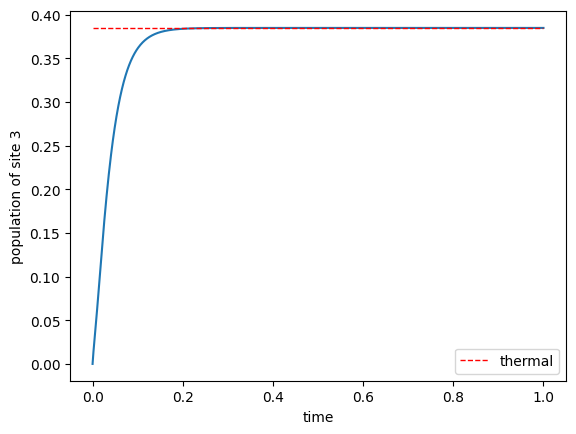

In [32]:
# import matrix exponential
from scipy.linalg import expm

# transformation to the eigenbasis of the Hamiltonian
U = ekets

# thermal state in the Basis of the Hamiltonin
rho_thermal = U@G(H,T)@U.conj().T

# initial state in the basis of the Hamiltonian
psi0 = U@basis[0]

# initial state as density operator
rho0 = np.outer(psi0,psi0.conj().T)

# target state
target = U@basis[2]

# target operator
O = np.outer(target,target.conj().T)

# initial and final time
t,tf = 0,1

# number of steps
steps = 1000

# times
times = np.linspace(0,tf,steps)

# finite difference
dt = times[1]-times[0]

# data 
data = []

# calculate propagator
P = expm(R*dt) 

# initialize state
rho = rho0

# propagate
for k in range(steps):
    # append result
    data.append( np.real(np.trace( O @ rho )) ) # calculate population of target state
    # vectorised state operator
    rho_vec = np.reshape(rho,(dim**2,1))
    # propagate
    rho_vec = P@rho_vec # propagate state
    # bring back to operator shape
    rho = np.reshape(rho_vec,(dim,dim))

# figure
fig, ax = plt.subplots()
# plot the time-dependent population of the target site
ax.plot(times, data)
# plot the population of the target site at thermal equilibrium
ax.hlines(np.trace(rho_thermal@O),times[0],times[-1], colors = 'red', 
          linewidths = 1, linestyles = 'dashed', label = 'thermal');
ax.set_xlabel('time');
ax.set_ylabel('population of site 3');
ax.legend();

##### Population of the reaction centre

Calculate the population of the reaction centre assuming that:

- Exciton transfer to the reaction centre can only occur from the target site $i=3$;
- $\gamma_0 = 1$ is the transfer rate from the target site (3) to the reaction centre;
- $\tau = 10$ is the exciton lifetime, identical for every exciton (on every site);

To do that, you can consider an additional state $|\mathrm{rc}\rangle$ corresponding to the reaction centre, and an additional state corresponding to the ground state (vacuum) of the system $|0\rangle$, such that:

- $|3\rangle \to |\mathrm{rc}\rangle$ occurs at rate $\gamma_0$,
- $|i\rangle \to |0\rangle$ occurs at rate $\tau$ for every site $i  = 1, \dots, 7$.

In [56]:
# add the vacuum state and the reaction centre at the end, with zero energy
energies = [280,420,0,175,320,360,260,0,0]

# dimension
dim = len(energies)

# basis
basis = np.eye(dim)

# build Hamiltonian from the list of energies
H = np.diag(energies)

# H eigenbasis
evals, ekets = eigensorter(H)

# transformation to the eigenbasis of the Hamiltonian
U = ekets

# add couplings
# loop over the coupling assigning each value to indices and coupling strength
for i,j,V in couplings:
    # compose the coupling in operator form
    coupling = V * np.outer(basis[i],basis[j].conj().T)
    # ad the coupling and its conjugate transpose
    H = H + (coupling + coupling.conj().T)

# create the Bloch-Redfield tensor for the relaxation process

# cromophore states
chromphores = basis[0:7]
# vacuum
vac = basis[-2]
# reaction centre
rc = basis[-1]
# coupling operators only for the FMO chromophores (elements from 0 to 6)
a_ops = [[np.outer(b,b.conj().T),NPS] for b in chromphores]

# Bloch-Redfield tensor in H basis
R = BR_tensor(H, a_ops)

# rates to vacuum and reaction centre
g0,tau = 1,10

# Lindblad operators for the incoherent transition 
# NOTE: to add them to R correctly they must be in H eigenbasis
c_ops = ([np.sqrt(1/tau)*np.outer(U@vac,(U@chromophore).conj().T) for chromophore in chromphores]
         +[np.sqrt(g0)*np.outer(U@rc,(U@chromphores[2]).conj().T)])

# function to get the Liouville superoperator
def liouvillian(H, c_ops = []):
    d = len(H) # dimension of the system
    superH = -1j * ( np.kron(np.eye(d),H)-np.kron(H.T,np.eye(d)) ) # Hamiltonian part
    superL = sum([np.kron(L.conjugate(),L) 
                  - 1/2 * ( np.kron(np.eye(d),L.conjugate().T.dot(L)) +
                            np.kron(L.T.dot(L.conjugate()),np.eye(d)) 
                          ) for L in c_ops])
    return superH + superL

# Liouvillian (without any Hamiltonian
super = liouvillian(0*H, c_ops)

# sum superoperators
Rtot = R + super

### Propagate

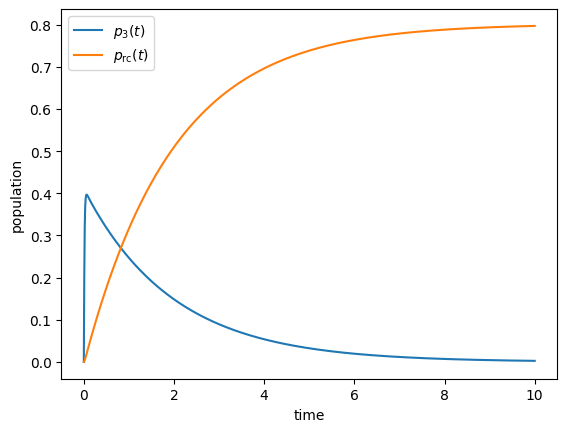

In [57]:
# initial state in the basis of the Hamiltonian
psi0 = U@basis[0]

# initial state as density operator
rho0 = np.outer(psi0,psi0.conj().T)

# target state
target = U@basis[2]

# target operator
O = np.outer(target,target.conj().T)

# reaction centre operator
RC = np.outer(U@rc, (U@rc).conj().T)

# initial and final time
t,tf = 0,10

# number of steps
steps = 1000

# times
times = np.linspace(0,tf,steps)

# finite difference
dt = times[1]-times[0]

# data 
data_target = []
data_rc = []

# calculate propagator
P = expm(Rtot*dt) 

# initialize state
rho = rho0

# propagate
for k in range(steps):
    # append result
    data_target.append( np.real(np.trace( O @ rho )) ) # calculate population of target state
    data_rc.append( np.real(np.trace( RC @ rho )) ) # calculate population of target state
    # vectorised state operator
    rho_vec = np.reshape(rho,(dim**2,1))
    # propagate
    rho_vec = P@rho_vec # propagate state
    # bring back to operator shape
    rho = np.reshape(rho_vec,(dim,dim))

# figure
fig, ax = plt.subplots()
# plot the time-dependent population of the target site
ax.plot(times, data_target, label = r'$p_3(t)$')
ax.plot(times, data_rc, label = r'$p_\mathrm{rc}(t)$')
# plot the population of the target site at thermal equilibrium
ax.set_xlabel('time');
ax.set_ylabel('population');
ax.legend();